# DSCI 100: Final Project Report, Group 28

## Introduction

The PLAI group at UBC, using a MineCraft server, collected data about how people play video games through automated tracking and user-reported information. Two datasets were provided: `sessions.csv` and `players.csv`.

Player characteristics are often indicative of the preferences that players have towards video games (Tondello & Nacke, 2019). As such, understanding the characteristics of players who subscribe to game-related content is important for developers. Game-related newsletter effectively provides key details such as version updates, event schedules, and system adjustments. Subscription behavior not only reflects players' demand for information but also indicates their level of engagement and investment in the game. For developers, identifying which player groups are more willing to receive game-related content through subscription allows for more precise targeting of different groups' preferences. This helps optimize server operation strategies to attract more users. 

The goal of this analysis is to answer the question: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types? 

To address this broader question, this analysis will use the data in the `players.csv` dataset to answer the more specific question: **Can age and the total hours played by a player predict whether they subscribe to a game-related newsletter?**

The `players.csv` dataset contains the data necessary to answer this specific question, formatted already into a table such that the explanatory variables, `played_hours` and `Age`, are in their own columns and can be analyzed to see if they can predict the response variable, `subscribe` (whether or not the player subscribes to the game-related newsletter). Each player is one observation in this dataset, so we can compare these variables for each player and see if the explanatory variables are good predictors.  

By determining whether `Age` and `played_hours` can predict subscription status, we can identify which player characteristics and behaviours are most closely associated with engagement in game-related content.


**For flow, the code to load and observe the dataset and calculate summary statistics is written in the Methods section. This section is only for descriptions of data derived from the code output from Methods.**

#### `players.csv` Overview

The `players.csv` dataset provides information about each player. There are 196 observations and the dataset contains 7 variables:

| Variable | Data type | Meaning | Variable details |
| :------- | :------- | :------- | :------- |
| experience | Character | Experience level of the player | Pro/Veteran/Amateur/Regular/Beginner |
| subscribe | Logical | Whether the player subscribed to a game-related newsletter | True/False |
| hashedEmail | Character | Anonymized identifier for each player's email | - |
| played_hours | Double (Numeric) | Total time spent playing for each player in hours | - |
| name | Character | Player name | - |
| gender | Character | Player gender | Male/Female/Non-binary/Prefer not to say/Agender/Two-Spirit/Other |
| Age | Double (Numeric) | Player age in years | - |

Potential problems in this dataset are:
- The values in the `subscribe` variable column are of the logical data type, and are not very descriptive of what the data means. They could be changed to factor type and renamed to describe the status of a player's subscription.
- There are missing (NA) values for some observations in the `Age` variable; these need to be dealt with prior to gathering summary statistics.
- It's not clear how the data was collected, such as how player experience was gauged (self-reported? Other testing metrics?).
- `name` is not necessary, especially with `hashedEmail` as an identifier.

#### Summary Statistics for `players.csv` Dataset

The mean age of each player is 21.14 years, with a range from 9 to 58 years. The mean hours played per player is 5.90 hours, with a range of 0 to 223.1 hours. 

| Variable | Mean | Min | Max |
| :------- | :------- | :------- | :------- |
| Age (years) | 21.14 | 9 | 58 |
| Hours played per player | 5.90 | 0 | 223.1 |

## Methods & Results

#### Load Libraries and Data

The first step is to load libraries and read in the dataset so that we can observe the dataset, obtain summary statistics, and describe it. **Descriptions and summary statistics obtained from exploratory analysis are reported in the Introduction.**

In [17]:
#Loading libraries

library(tidyverse)
library(repr)
library(tidymodels)

options(repr.matrix.max.rows = 6)

In [18]:
#Reading in data from the players dataset

players_url <- "https://drive.google.com/uc?export=download&id=1wPawgc5uTyx2Btw3NTQR8VPvyRDrLwqT"

players_data <- read_csv(players_url)
players_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


#### Tidying Data

The data now must be wrangled and tidied so that it is ready for analysis. To do this, we remove the rows with NA and convert the columns into the appropriate data type. In the `subscribe` column, `FALSE` and `TRUE` values were changed to `Unsubscribed` and `Subscribed` to make this more descriptive.

In [19]:
#Tidying data: removing rows with NA, converting to correct data types, and changing to descriptive names

players_data <- players_data |>
                filter(!is.na(Age), !is.na(played_hours), !is.na(subscribe)) |>
                mutate(subscribe = as.factor(subscribe),
                       subscribe = recode(subscribe, "FALSE" = "Unsubscribed", "TRUE" = "Subscribed"))
players_data

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,Subscribed,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,Subscribed,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,Unsubscribed,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,Unsubscribed,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,Unsubscribed,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,Unsubscribed,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


#### Summary Statistics Calculations

The next step is to perform a summary of the data for exploratory analysis.

In [20]:
#Players dataset: Max, Min, and Mean for each quantitative variable
player_max<- players_data |>
summarize(across(c(played_hours,Age),~round(max(.x, na.rm=TRUE),2)),statistic = "max")

player_min<- players_data|>
summarize(across(c(played_hours,Age),~round(min(.x, na.rm=TRUE),2)),statistic = "min")

player_mean<- players_data|>
summarize(across(c(played_hours,Age),~round(mean(.x, na.rm=TRUE),2)),statistic = "mean")

player_stats <- bind_rows(player_max,player_min,player_mean)

player_stats

played_hours,Age,statistic
<dbl>,<dbl>,<chr>
223.1,58.00,max
0.0,9.00,min
5.9,21.14,mean


The mean age of each player is 21.14 years, with a range from 9 to 58 years. The mean hours played per player is 5.90 hours, with a range of 0 to 223.1 hours. This is also reported in a table in the Introduction.

In [21]:
subscribe_frequency <- players_data|>
count(subscribe)|>
mutate(percent = n/sum(n) *100)|>
arrange(desc(n))
subscribe_frequency

subscribe,n,percent
<fct>,<int>,<dbl>
Subscribed,142,73.19588
Unsubscribed,52,26.80412


73.20% of players are subscribed to the newsletter, and 26.80% are not.

#### Exploratory Visualizations

As part of exploratory analysis, we will create a visualization to explore potential relationships between subscription status of players based on their age and total hours played.

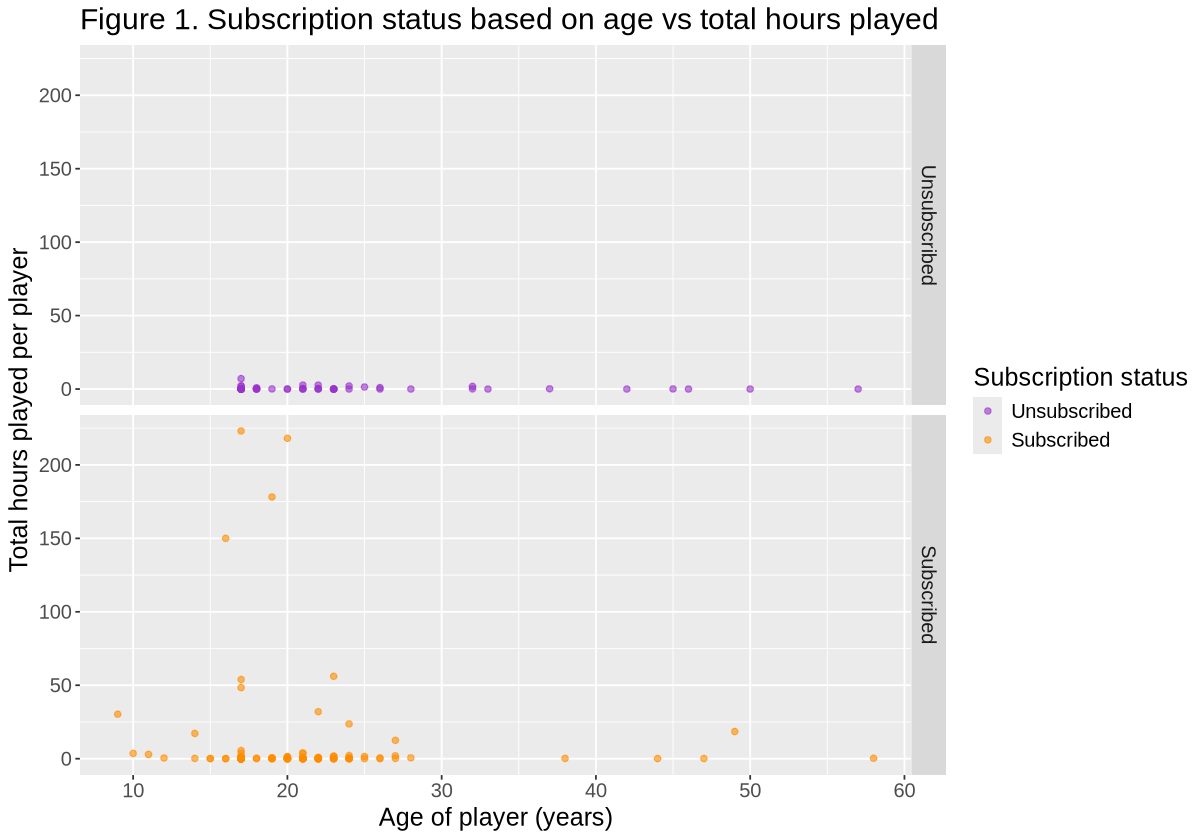

In [22]:
options(repr.plot.width = 10)

age_vs_played_hours <- players_data |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.6) +
    labs(x = "Age of player (years)",
         y = "Total hours played per player",
         title = "Figure 1. Subscription status based on age vs total hours played",
         color = "Subscription status") +
    scale_color_manual(values = c("Unsubscribed" = "darkorchid", "Subscribed" = "darkorange")) +
    theme(text = element_text(size = 15))+
    facet_grid(rows=vars(subscribe)) #Split into two subgraphs by subscription status
age_vs_played_hours

This scatterplot indicates that there is no relationship between age and total hours played. 

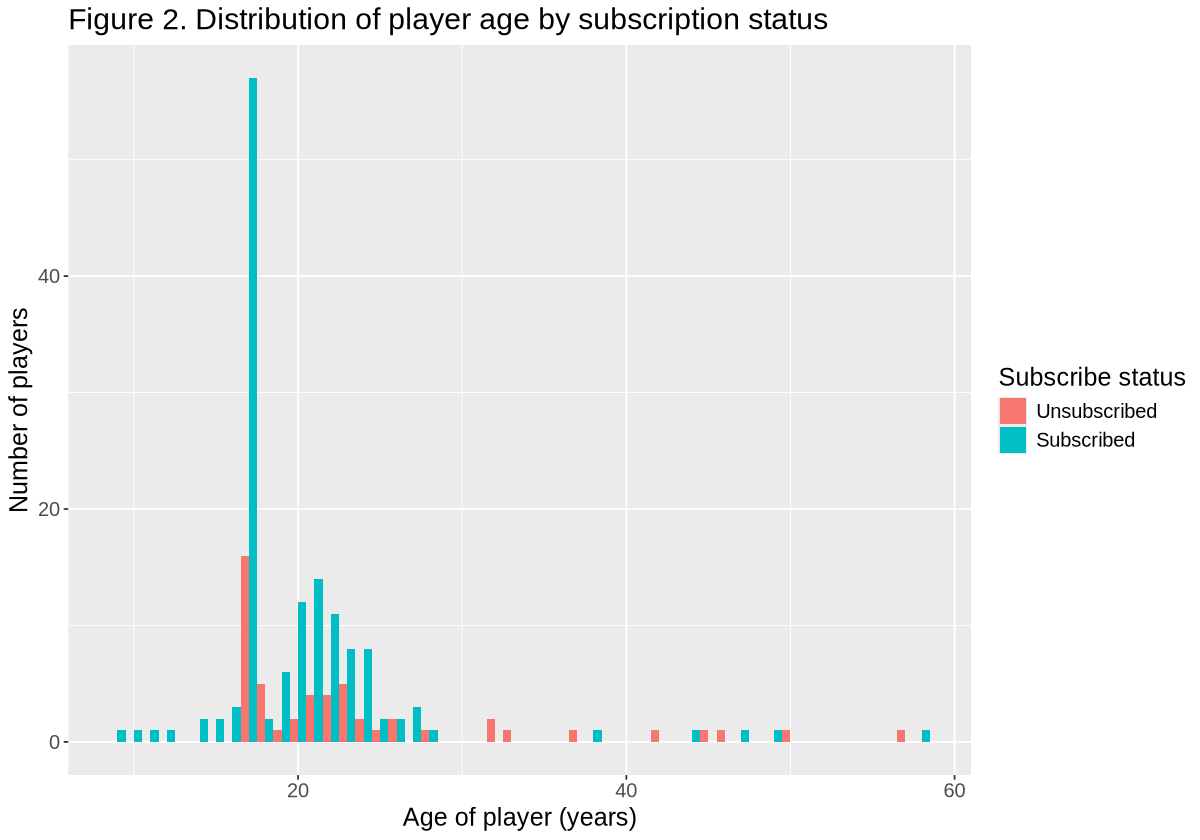

In [24]:
options(repr.plot.width = 10)

age_vs_subscribe <- players_data|>
    ggplot(aes(x=Age, fill=subscribe))+
    geom_histogram(binwidth=1,position="dodge")+
    labs(x="Age of player (years)", y="Number of players",fill="Subscribe status")+
    ggtitle("Figure 2. Distribution of player age by subscription status") +
    theme(text = element_text(size = 15))
age_vs_subscribe

The age of subscribed and unsubscribed players is concentrated around 20 years old, however the number of subscribed players in this age range is much larger than that of unsubscribed players. 

For players of very young ages (around 15 our younger), all are subscribed.

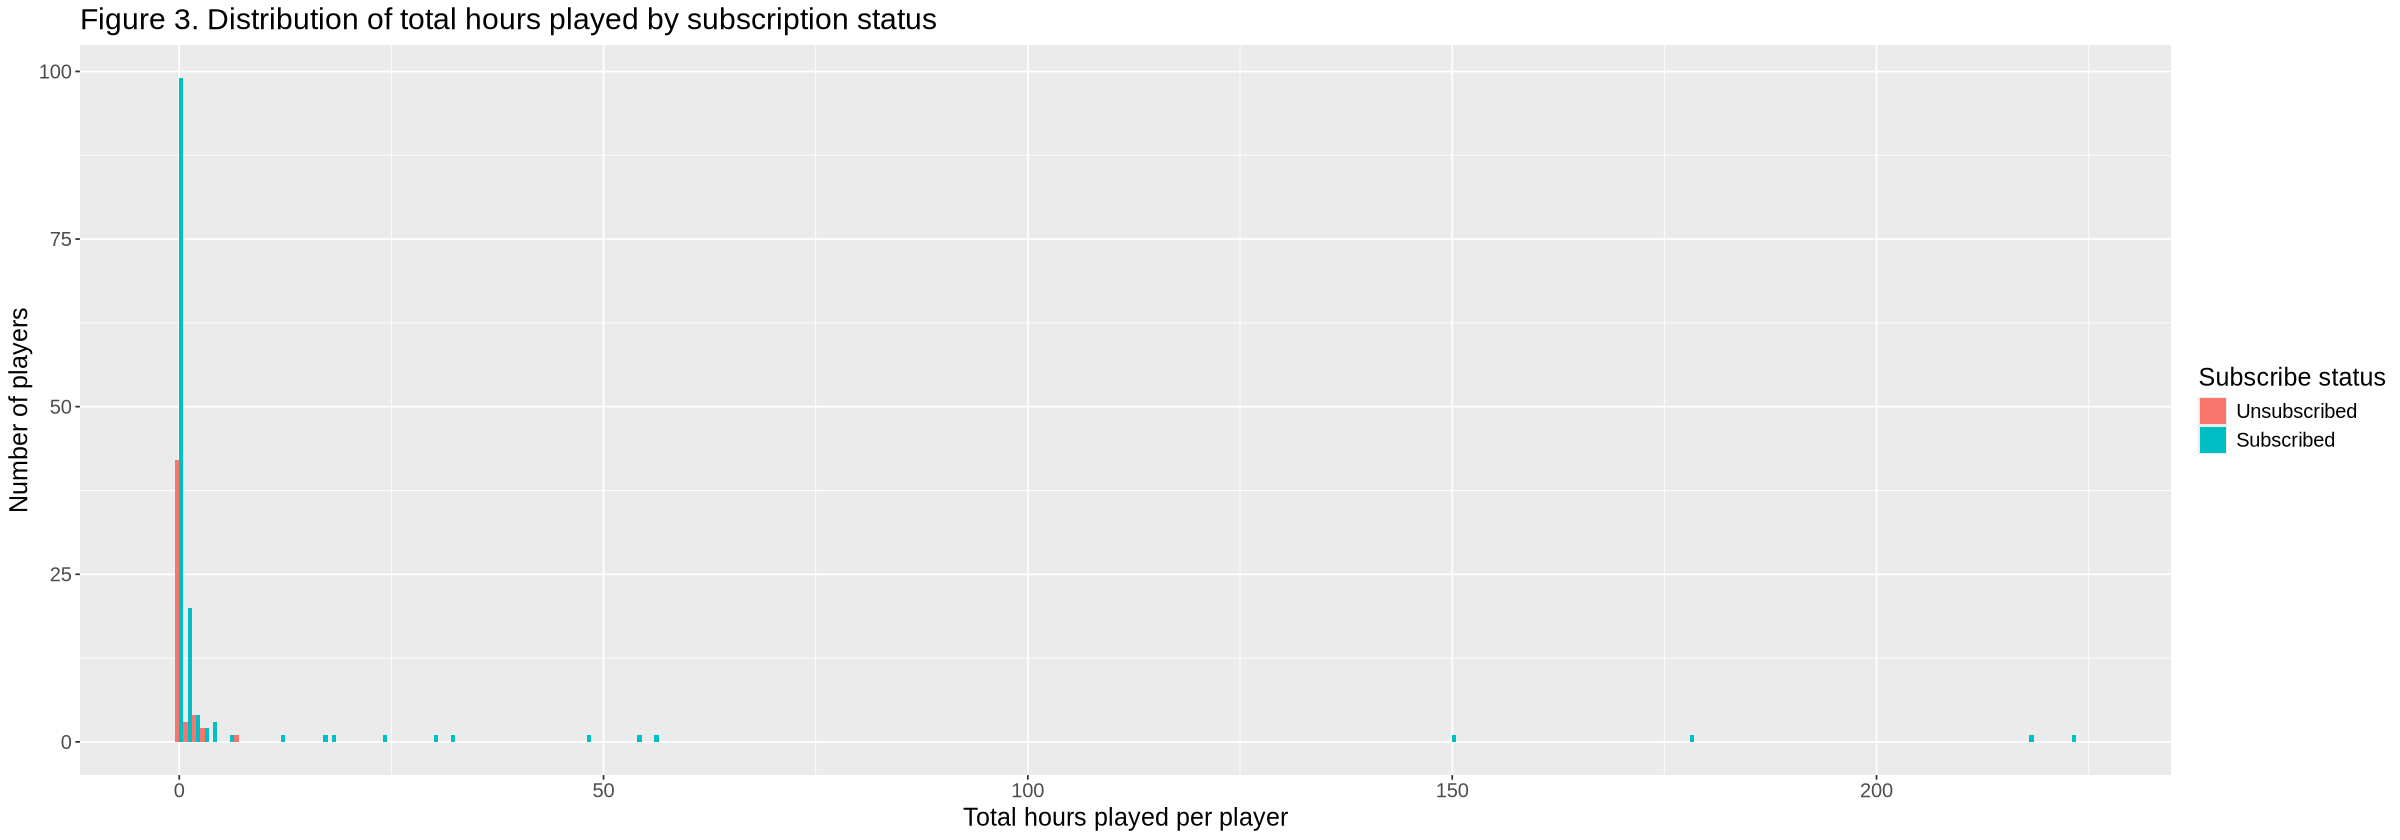

In [25]:
options(repr.plot.width = 20)

played_hours_vs_subscribe <- players_data|>
    ggplot(aes(x=played_hours, fill=subscribe))+
    geom_histogram(binwidth=1,position="dodge")+
    labs(x="Total hours played per player", y="Number of players",fill="Subscribe status")+
    ggtitle("Figure 3. Distribution of total hours played by subscription status") +
    theme(text = element_text(size = 15))
played_hours_vs_subscribe

Both subscribed and non-subscribed players' total played hours are concentrated between 0 and 5 hours, but the number of subscribed players in this time range is much larger than that of unsubscribed players.

Most users have not played more than 50 hours, but of the ones that do, all have subscribed. Individuals that have played a lot of hours tend to be subscribed and also younger -- no one over the age of 30 has played more than 25 hours. These, especially hours played, are therefore potential predictors for subscription status.

#### Data Analysis

We are using K-nearest neighbors classification (a supervised task) on the `players.csv` dataset, as we are using two predictors (`Age` and `hours_played`) to predict a categorical response variable (`subscribe`, which is player subscription status). 

Steps for data analysis:
1. **Dataset preparation**  
   We prepared the `players.csv` dataset for analysis by selecting the `Age` and `played_hours` columns. The dataset was tidied in an earlier step.
2. **Split the cleaned data**  
   The dataset was split into training and testing sets by setting a 75-25% split, respectively. The training dataset was used to train the model, and the testing dataset was reserved to evaluate the performance on unseen data.
3. **Preprocessing**  
   We created a recipe to scale the `Age` and `played_hours` predictors, then built a KNN classifier and fit it to the training set.
5. **Cross-validation**  
   To select the optimal number of nearest neighbors (k), we used 5-fold cross-validation on the training set.
   We tested k values ranging from 1 to 20 and selected the k with the highest prediction accuracy.
6. **Evaluation**  
   We retrained the model using the optimal k on the full training set and evaluated its performance on the testing set to measure prediction accuracy. Using the confusion matrix, we calculated precision and recall. 

[1] 3

              Truth
Prediction     Unsubscribed Subscribed
  Unsubscribed            4          4
  Subscribed              9         32

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939


[1] 0.7804878

[1] 0.8888889

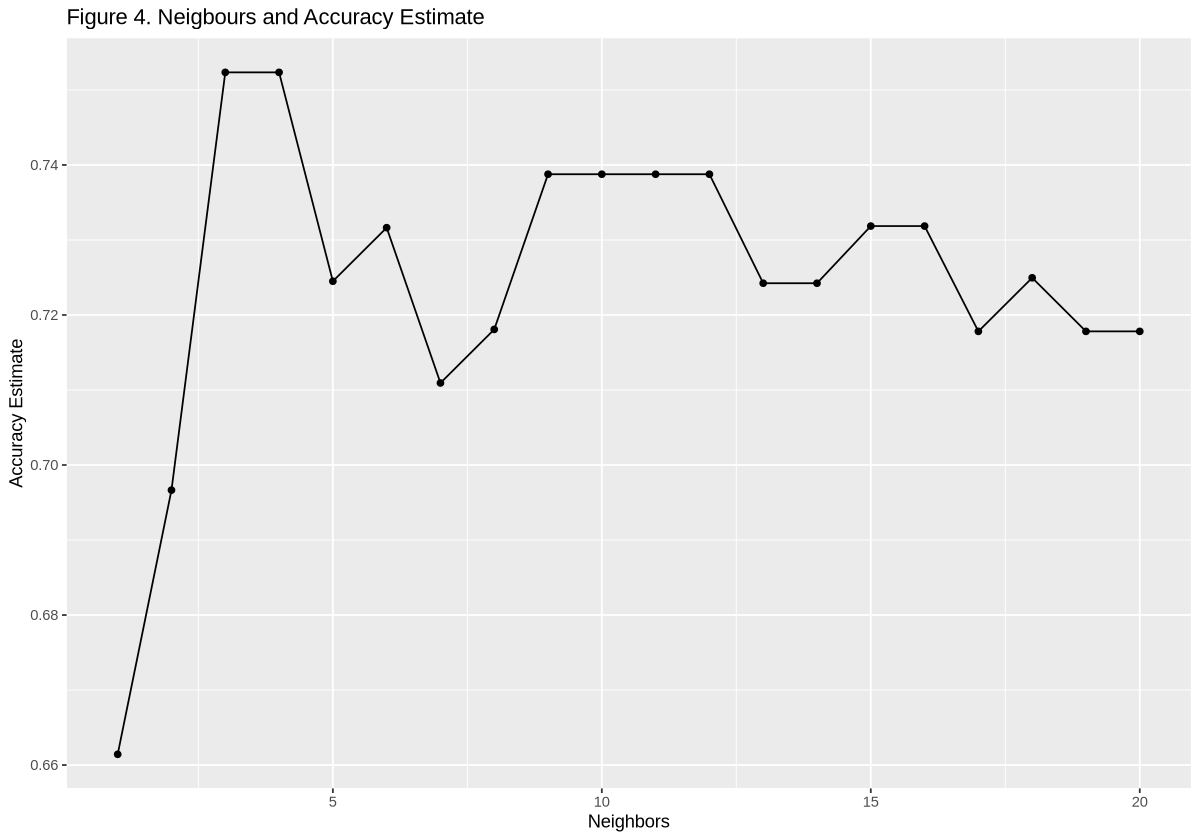

In [27]:
set.seed(1000)
options(repr.plot.width = 10)

#Step 1: Select columns
players_data_clean <- players_data |> 
    select(subscribe, played_hours, Age) 

#Step 2: Splitting Data.
players_split <- initial_split(players_data_clean, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

#Step 3: Preprocessing.
players_recipe <- recipe(subscribe ~ played_hours + Age, data = players_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

#Step 4: Cross-Validation.
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

knn_results <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = players_vfold, grid = k_vals) |>
      collect_metrics()

accuracies <- knn_results |> 
      filter(.metric == "accuracy") |>
      select(neighbors, mean)

best_k <- accuracies |> 
    arrange(desc(mean)) |>
    head(1) |> 
    pull(neighbors)
best_k

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Figure 4. Neigbours and Accuracy Estimate")
accuracy_versus_k

#Step 5: Evaluation:

#New model with the best K.
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(data = players_train)

player_predictions <- predict(players_fit, new_data = players_test) |>
    bind_cols(players_test)

#Creating a confusion matrix to show the predictions of the test dataset.
conf_mat <- conf_mat(player_predictions, truth = subscribe, estimate = .pred_class)
conf_mat

#Using new model to predict accuracy of the test dataset.
player_metrics <- player_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
player_metrics

#Calculating precision and recall
precision <- 32/(32+9)
precision

recall <- 32/(32+4)
recall

#### Visualization of Analysis

In [22]:
plot_data<- player_predictions |>
    rename(predicted_subscribe = .pred_class,
           true_subscribe=subscribe)|>
    select(Age, played_hours, true_subscribe, predicted_subscribe)
plot_data

Age,played_hours,true_subscribe,predicted_subscribe
<dbl>,<dbl>,<fct>,<fct>
17,3.8,Subscribed,Subscribed
19,0.0,Subscribed,Subscribed
17,0.0,Subscribed,Subscribed
⋮,⋮,⋮,⋮
17,0.0,Subscribed,Subscribed
22,0.3,Unsubscribed,Subscribed
57,0.0,Unsubscribed,Subscribed


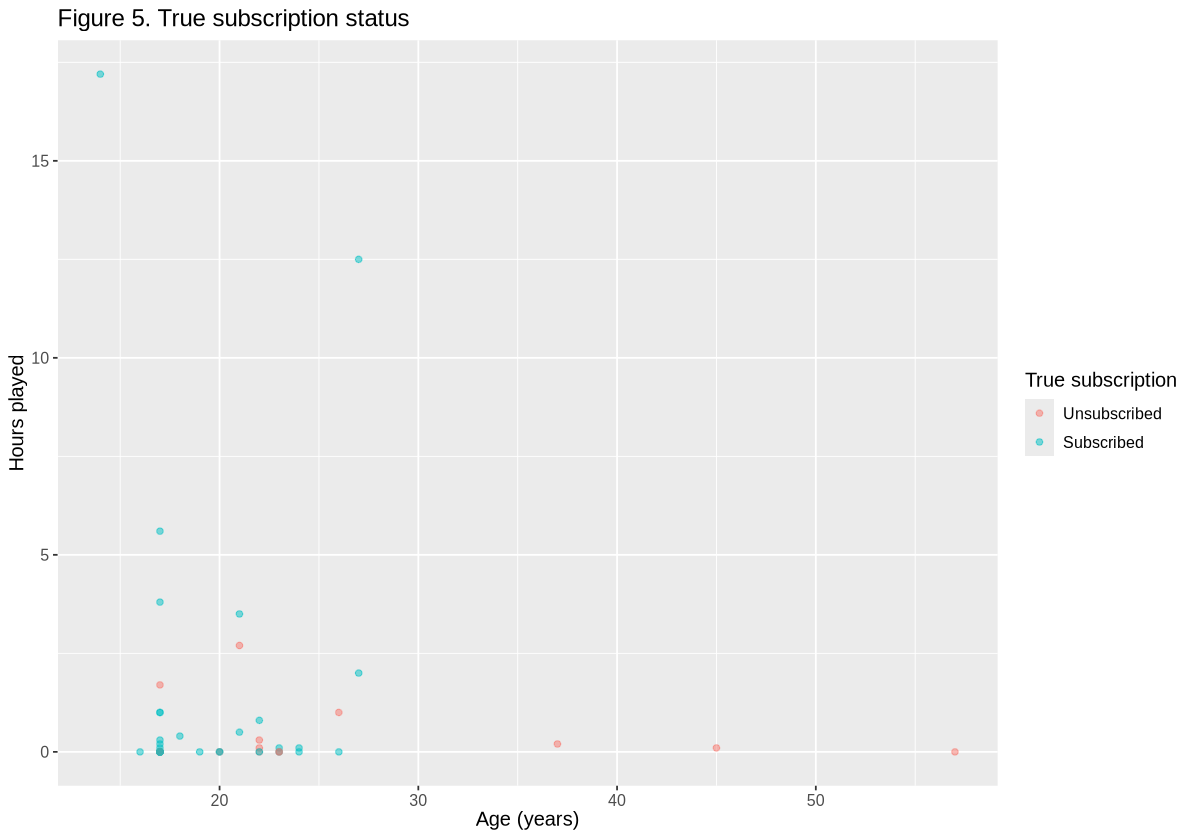

In [23]:
true_plot <- plot_data |>
    filter(played_hours<=25)|>
    ggplot(aes(x=Age,y=played_hours,color=true_subscribe))+
    geom_point(alpha=0.5)+
    labs(x="Age (years)", y="Hours played", color="True subscription")+
    ggtitle("Figure 5. True subscription status")+
    theme(text=element_text(size=12))
true_plot

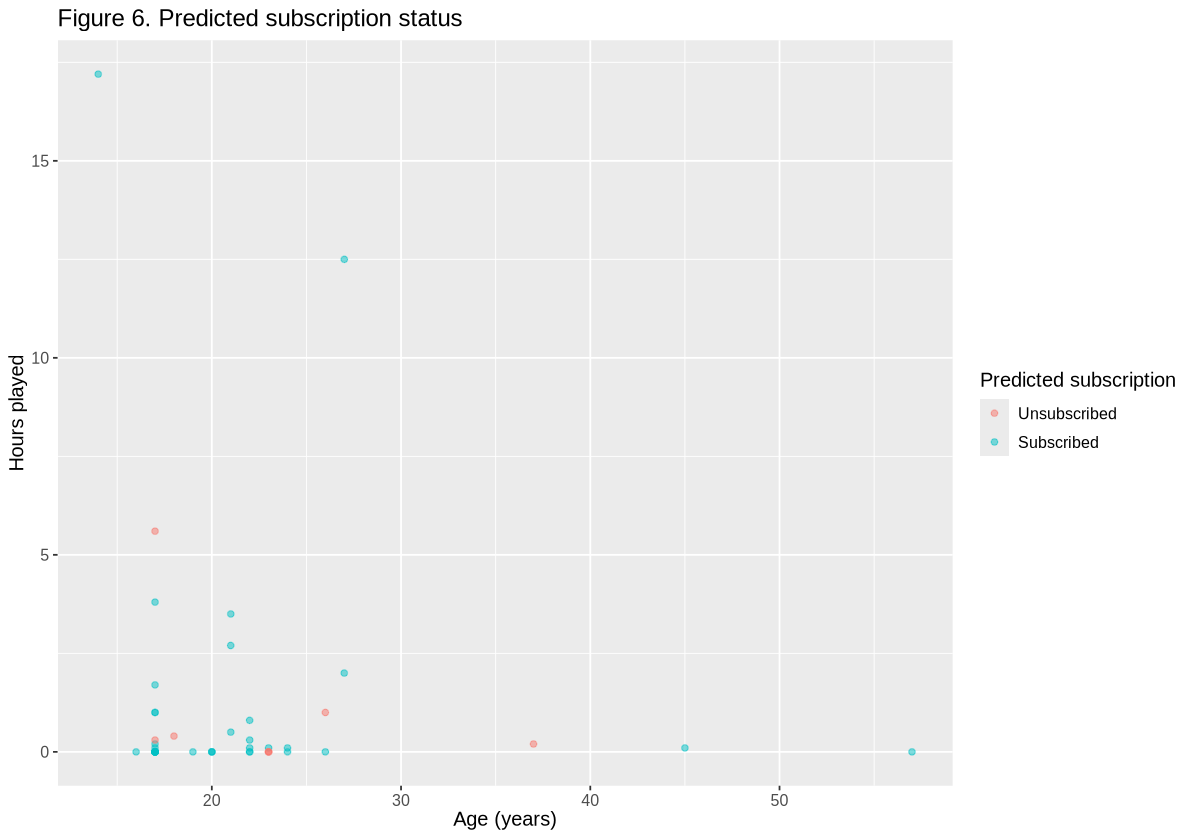

In [24]:
pred_plot <- plot_data|>
    filter(played_hours<= 25)|>
    ggplot(aes(x=Age,y=played_hours,color=predicted_subscribe))+
    geom_point(alpha=0.5)+
    labs(x="Age (years)", y="Hours played", color="Predicted subscription")+
    ggtitle("Figure 6. Predicted subscription status")+
    theme(text=element_text(size=12))
pred_plot

In [25]:
#Mutating dataset to include a column that describes whether the observation was correctly classified or not
#Changed data type to factor, and renamed values to be more descriptive

correct_plot_data <- plot_data |>
    mutate(correct_prediction = (true_subscribe == predicted_subscribe),
           correct_prediction = as.factor(correct_prediction),
           correct_prediction = recode(correct_prediction, "FALSE" = "Incorrect", "TRUE" = "Correct"))
correct_plot_data

Age,played_hours,true_subscribe,predicted_subscribe,correct_prediction
<dbl>,<dbl>,<fct>,<fct>,<fct>
17,3.8,Subscribed,Subscribed,Correct
19,0.0,Subscribed,Subscribed,Correct
17,0.0,Subscribed,Subscribed,Correct
⋮,⋮,⋮,⋮,⋮
17,0.0,Subscribed,Subscribed,Correct
22,0.3,Unsubscribed,Subscribed,Incorrect
57,0.0,Unsubscribed,Subscribed,Incorrect


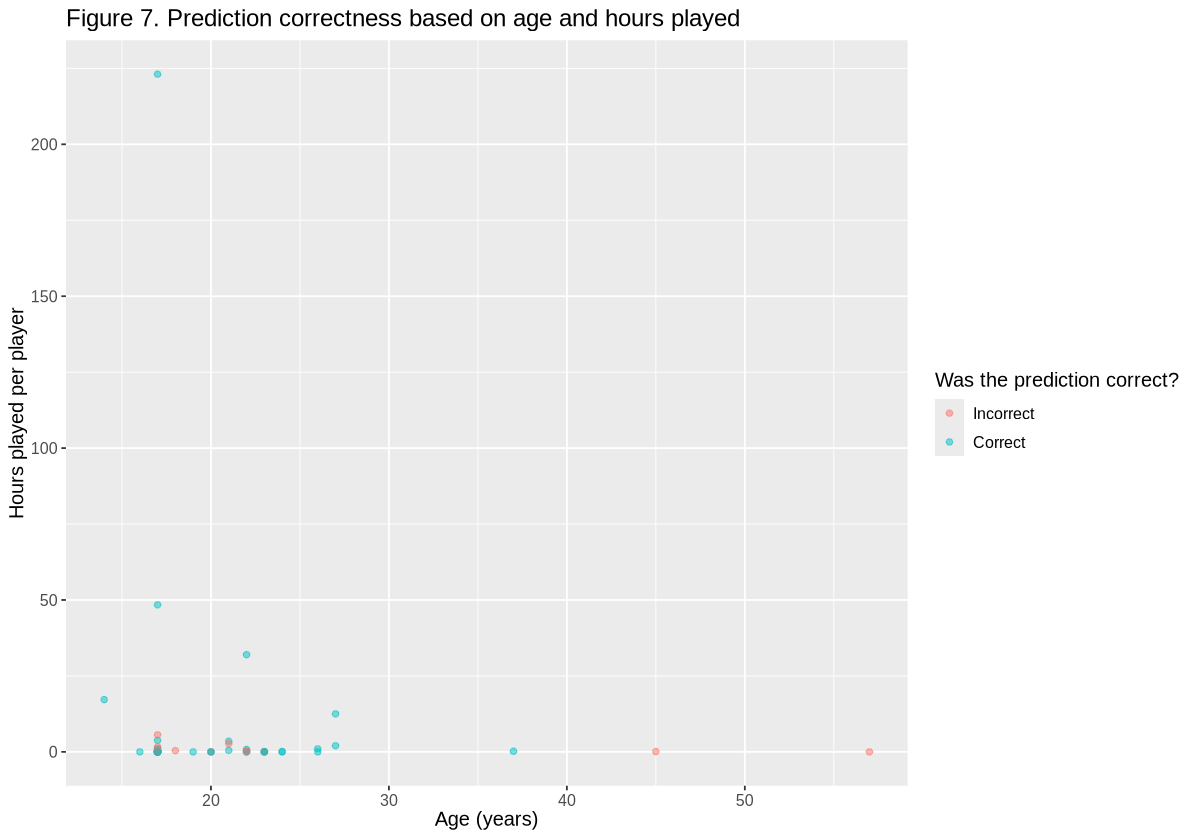

In [26]:
#Plot to display which observations were correctly predicted by our classifier and which were not

correct_plot <- correct_plot_data|>
    ggplot(aes(x=Age,y=played_hours,color=correct_prediction))+
    geom_point(alpha=0.5)+
    labs(x="Age (years)", y="Hours played per player", color="Was the prediction correct?")+
    ggtitle("Figure 7. Prediction correctness based on age and hours played")+
    theme(text=element_text(size=12))
correct_plot

## Discussion

We built a classifier based on age and hours played per player to attempt to predict subscription status. Our classifier was able to predict subscription status with a 73.47% accuracy. While this is not low accuracy, it is also not particularly high. There is higher recall (88.89%) than there is precision (78.04%), indicating that our classifier is able to catch most cases where users do subscribe to the newsletter, but often classifies users as subscribed when they are unsubscribed. Despite most of the subscription statuses being correctly predicted, this still classifier had a high rate of errors. Therefore, age and hours played may not be the best predictors possible. 

This was somewhat expected from the preliminary analysis; we saw from our exploratory visualizations that the age of players is concentrated around 20 years old, but for very young players, all are subscribed, indicating that age could be a potential predictor of subscription status. Additionally, in our plot of the distribution of hours played based on subscription status, most users have not played more than 50 hours, but of the ones that do, all have subscribed. Individuals that have played a lot of hours tend to be subscribed and also younger -- no one over the age of 30 has played more than 25 hours. This indicates also that hours played can be a potential predictor of subscription status. When we looked at both of them together, however, they were not strong predictors. It is possible that the influence of outliers have affected this outcome; with outliers, because they are not similar to the rest of the data, may affect the accuracy of the predictions made.

These findings can be used to inform developers on what characteristics are indicative of whether players will subscribe. Advertisement and marketing can be expensive (Koster, 2018), so determining who it is best used on helps save on advertisement costs and avoids waste. If younger age and more hours played are predictors of subscribing to the newsletter, then the developers may want to target their marketing strategies to new players that are young and play a lot to entice them to subscribe, while saving costs on other users that are not very likely to subscribe. At the same time, if age and hours played are not the strongest predictors of subscription status, the developers may want to look at other characteristics that may better predict whether users will subscribe, and can focus their marketing on those characteristics instead. 

This analysis could lead to more investigations into how significant each predictor is to subscription status of a player, and could be used to answer questions like these:
- Are age and hours played predictors of subscription statuses in different datasets or games?
- Is the subscription status also dependent on the game they are playing?
- Can other models, such as machine learning, more accurately predict subscription status using these predictors compared to the K-nearest neighbors classification model that we have utilized?

## References

Koster, R. (2018). _The cost of games_. Game Developer. https://www.gamedeveloper.com/business/the-cost-of-games

Tondello, G. F., & Nacke, L. E. (2019). _Player Characteristics and Video Game Preferences_. Annual Symposium on Computer-Human Interaction in Play. Association for Computing Machinery, New York, NY, USA, 365–378. https://doi.org/10.1145/3311350.3347185